In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import pandas as pd
pd.options.display.max_rows = 1000
import gc
import numpy as np
from tqdm import tqdm
from glob import glob
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.optim import SparseAdam, Adam
torch.backends.cudnn.benchmark = True
print(torch.__version__)
import cudf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pickle
import random
import math
import time

def freemem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    gc.collect()
    return

device = 'cuda'
USE_GPU = torch.cuda.is_available()
print('Is GPU available?', USE_GPU)

1.13.1+cu117
Is GPU available? True


In [2]:
# !pip uninstall torch -y
# !pip install torch==1.12.1 torchvision torchaudio

# point to all your training parquet files
files = (
    list(glob('fold/train-full-split*')) +
    list(glob('fold/valid-trim-split*')) +
    list(glob('fold/test-full-split*'))
)
print(len(files))

95


In [3]:
train = pd.read_parquet(files)
train = cudf.from_pandas(train); gc.collect()
train = train.sort_values(['session', 'ts'], ascending=[True, True]).reset_index(drop=True)
freemem(train)

print(train.shape)
train.head()

(178566880, 4)


,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [4]:
train[f'ts_diff'] = train.groupby('session')['ts'].shift(1).fillna(0).astype('int32')
train[f'ts_diff'] = (train[f'ts'] - train[f'ts_diff'])
train[f'ts_diff'] = train[f'ts_diff'].clip(0, 24*60*60)
train.loc[train.ts_diff<12*60*60 , f'ts_diff'] = 0
train.loc[train.ts_diff>=12*60*60 , f'ts_diff'] = 1
gc.collect()
train[f'subses'] = train.groupby('session')['ts_diff'].cumsum()
print(train[f'subses'].max())

train[f'subses'] = (train[f'session']*128 + train[f'subses']).factorize()[0]
print(train[f'ts_diff'].mean())
train.head(60)

23
0.16806949306612737


,session,aid,ts,type,ts_diff,subses
0,0,1517085,1659304800,0,1,0
1,0,1563459,1659304904,0,0,0
2,0,1309446,1659367439,0,1,1
3,0,16246,1659367719,0,0,1
4,0,1781822,1659367871,0,0,1
5,0,1152674,1659367885,0,0,1
6,0,1649869,1659369893,1,0,1
7,0,461689,1659369898,1,0,1
8,0,305831,1659370027,2,0,1
9,0,461689,1659370027,2,0,1


In [5]:
train['type'] = train['type'].astype('int32')
train[f'lag_type'] = train.groupby('subses')['type'].shift(1).fillna(-1).astype('int32')
for lag in range(15):
    train[f'lag{lag}'] = train.groupby('subses')['aid'].shift(lag).fillna(-1).astype('int32')
    gc.collect()
    
del train['aid']
freemem(train); gc.collect()
gc.collect()

train.head(60)

,session,ts,type,ts_diff,subses,lag_type,lag0,lag1,lag2,lag3,...,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
0,0,1659304800,0,1,0,-1,1517085,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,0,1659304904,0,0,0,0,1563459,1517085,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,1659367439,0,1,1,-1,1309446,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,1659367719,0,0,1,0,16246,1309446,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,1659367871,0,0,1,0,1781822,16246,1309446,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,0,1659367885,0,0,1,0,1152674,1781822,16246,1309446,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,0,1659369893,1,0,1,0,1649869,1152674,1781822,16246,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,0,1659369898,1,0,1,1,461689,1649869,1152674,1781822,...,1309446,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,0,1659370027,2,0,1,1,305831,461689,1649869,1152674,...,16246,1309446,-1,-1,-1,-1,-1,-1,-1,-1
9,0,1659370027,2,0,1,2,461689,305831,461689,1649869,...,1781822,16246,1309446,-1,-1,-1,-1,-1,-1,-1


In [6]:
print(train.shape)
del train['ts_diff']; gc.collect()

#train = train.loc[(train['type'] == 0) & (train['lag1'] >= 0)].reset_index(drop=True)
train = train.loc[(train['lag1'] >= 0)].reset_index(drop=True)
#del train['type']
gc.collect()

for i in range(1, 15):
    print(i)
    train[f'lag{i}'] = train[f'lag{i}'].clip(0, None)
freemem(train); gc.collect()

print(train.shape)
train.head(60)

(178566880, 21)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
(148555235, 20)


,session,ts,type,subses,lag_type,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
0,0,1659304904,0,0,0,1563459,1517085,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1659367719,0,1,0,16246,1309446,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1659367871,0,1,0,1781822,16246,1309446,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1659367885,0,1,0,1152674,1781822,16246,1309446,0,0,0,0,0,0,0,0,0,0,0
4,0,1659369893,1,1,0,1649869,1152674,1781822,16246,1309446,0,0,0,0,0,0,0,0,0,0
5,0,1659369898,1,1,1,461689,1649869,1152674,1781822,16246,1309446,0,0,0,0,0,0,0,0,0
6,0,1659370027,2,1,1,305831,461689,1649869,1152674,1781822,16246,1309446,0,0,0,0,0,0,0,0
7,0,1659370027,2,1,2,461689,305831,461689,1649869,1152674,1781822,16246,1309446,0,0,0,0,0,0,0
8,0,1659370064,0,1,2,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446,0,0,0,0,0,0
9,0,1659370067,0,1,0,1649869,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446,0,0,0,0,0


In [7]:
train['hour'] = ((train['ts']-train['ts'].min()) // (1*60*60)).astype('int32') 
train['hour'] = train['hour'].astype('int32') + train['lag0'].max() + 1
del train['ts'], train['subses']
freemem(train); gc.collect()

train['type'] = train['type'] + train['hour'].max() + 1
freemem(train); gc.collect()

train['lag_type'] = train['lag_type'] + train['type'].max() + 1
freemem(train); gc.collect()

train.tail(20)

,session,type,lag_type,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,hour
148555215,14571511,1856443,1856446,1587854,1839213,0,0,0,0,0,0,0,0,0,0,0,0,0,1856442
148555216,14571511,1856443,1856446,1839213,1587854,1839213,0,0,0,0,0,0,0,0,0,0,0,0,1856442
148555217,14571511,1856443,1856446,523147,1839213,1587854,1839213,0,0,0,0,0,0,0,0,0,0,0,1856442
148555218,14571515,1856443,1856446,779748,779748,0,0,0,0,0,0,0,0,0,0,0,0,0,1856442
148555219,14571515,1856443,1856446,781377,779748,779748,0,0,0,0,0,0,0,0,0,0,0,0,1856442
148555220,14571515,1856443,1856446,781377,781377,779748,779748,0,0,0,0,0,0,0,0,0,0,0,1856442
148555221,14571517,1856443,1856446,685092,1052749,0,0,0,0,0,0,0,0,0,0,0,0,0,1856442
148555222,14571517,1856443,1856446,712840,685092,1052749,0,0,0,0,0,0,0,0,0,0,0,0,1856442
148555223,14571517,1856443,1856446,1816382,712840,685092,1052749,0,0,0,0,0,0,0,0,0,0,0,1856442
148555224,14571519,1856443,1856446,1059174,1059174,0,0,0,0,0,0,0,0,0,0,0,0,0,1856442


In [8]:
train['lag0'].max(), train['hour'].max(), train['hour'].max()-train['lag0'].max()

(1855602, 1856442, 840)

In [9]:
gc.collect()
train.to_pandas().to_parquet('train-proc-10.parquet'); gc.collect()

0

# Reload the DataFrame using RAM to save GPU memory for the model.

In [2]:
train = pd.read_parquet('train-proc-10.parquet'); gc.collect()
print(train.shape)
print(train.head())

(148555235, 19)
   session     type  lag_type     lag0     lag1     lag2     lag3     lag4  \
0        0  1856443   1856446  1563459  1517085        0        0        0   
1        0  1856443   1856446    16246  1309446        0        0        0   
2        0  1856443   1856446  1781822    16246  1309446        0        0   
3        0  1856443   1856446  1152674  1781822    16246  1309446        0   
4        0  1856444   1856446  1649869  1152674  1781822    16246  1309446   

   lag5  lag6  lag7  lag8  lag9  lag10  lag11  lag12  lag13  lag14     hour  
0     0     0     0     0     0      0      0      0      0      0  1855603  
1     0     0     0     0     0      0      0      0      0      0  1855620  
2     0     0     0     0     0      0      0      0      0      0  1855620  
3     0     0     0     0     0      0      0      0      0      0  1855620  
4     0     0     0     0     0      0      0      0      0      0  1855621  


In [3]:
train['lag0'].max()

1855602

In [4]:
train.columns

Index(['session', 'type', 'lag_type', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
       'lag13', 'lag14', 'hour'],
      dtype='object')

In [5]:
for i in range(1, 15):
    train.loc[train[f'lag{i}']==0, f'lag{i}'] = i
train.head()

,session,type,lag_type,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,hour
0,0,1856443,1856446,1563459,1517085,2,3,4,5,6,7,8,9,10,11,12,13,14,1855603
1,0,1856443,1856446,16246,1309446,2,3,4,5,6,7,8,9,10,11,12,13,14,1855620
2,0,1856443,1856446,1781822,16246,1309446,3,4,5,6,7,8,9,10,11,12,13,14,1855620
3,0,1856443,1856446,1152674,1781822,16246,1309446,4,5,6,7,8,9,10,11,12,13,14,1855620
4,0,1856444,1856446,1649869,1152674,1781822,16246,1309446,5,6,7,8,9,10,11,12,13,14,1855621


# Define the FM model

In [6]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_aids=1855602+1, n_factors=32):
        super().__init__()
        self.aid_emb = nn.Embedding(n_aids, n_factors, sparse=False)
        self.aid_emb.weight.data.normal_(mean=0.0, std=0.001)
        self.head = nn.Linear(16, 1)
        
    def forward(self, lags, targets, types):
        targets = torch.repeat_interleave(targets.view(-1,1), lags.shape[1], dim=1)
        targets = self.aid_emb(targets)

        types = torch.repeat_interleave(types.view(-1,1), lags.shape[1], dim=1)
        types = self.aid_emb(types)

        targets = targets + types
        targets = torch.nn.functional.normalize(targets, p=2.0, dim=2, eps=1e-12)
        
        embs = self.aid_emb(lags) 
        embs = torch.nn.functional.normalize(embs, p=2.0, dim=2, eps=1e-12)
        embs = embs * targets
        embs = embs.sum(2)
        
        out = self.head(embs)
        return out.sigmoid()


model = MatrixFactorization(n_aids=1855602+1, n_factors=32)
model.train()

MatrixFactorization(
  (aid_emb): Embedding(1855603, 32)
  (head): Linear(in_features=16, out_features=1, bias=True)
)

# Try the model

In [7]:
lags = (1855603 * torch.rand(4, 16)).long()
targets = (1855603 * torch.rand(4)).long()
types  = (1855603 * torch.rand(4)).long()

lags, targets, types

(tensor([[ 730229, 1635402,  991044, 1116552,  677741, 1662319, 1256164,  968688,
          1494466,  650725, 1822308,  841791, 1536224, 1569751, 1359083,  999447],
         [ 143889,  106212,  286739,   61315, 1531317, 1006026,  178259, 1761624,
           843622,  317630, 1292765, 1305861,  158756,  105133, 1628859,  710572],
         [   4855, 1004709, 1337788, 1343301, 1261269, 1229538,  412595,   95402,
          1337460, 1106248, 1815600,  916642, 1489026,  973757, 1189353,  764750],
         [1172409, 1238846,  996666,  147488,  530691,  852626,  741643,  382289,
           856138, 1028240, 1175745,  375733,  662595, 1204928,  828015,  488577]]),
 tensor([ 588644,  160326, 1414233,  783194]),
 tensor([1714645, 1395669,  589623,  497384]))

In [8]:
model(lags, targets, types)

tensor([[0.5233],
        [0.5537],
        [0.5146],
        [0.5359]], grad_fn=<SigmoidBackward0>)

In [9]:
train.head()

,session,type,lag_type,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,hour
0,0,1856443,1856446,1563459,1517085,2,3,4,5,6,7,8,9,10,11,12,13,14,1855603
1,0,1856443,1856446,16246,1309446,2,3,4,5,6,7,8,9,10,11,12,13,14,1855620
2,0,1856443,1856446,1781822,16246,1309446,3,4,5,6,7,8,9,10,11,12,13,14,1855620
3,0,1856443,1856446,1152674,1781822,16246,1309446,4,5,6,7,8,9,10,11,12,13,14,1855620
4,0,1856444,1856446,1649869,1152674,1781822,16246,1309446,5,6,7,8,9,10,11,12,13,14,1855621


In [10]:
def train_loop(model, iterator, optimizer, clip):
    
    criterion = nn.BCELoss().to(device)
    model.train()
    epoch_loss = 0.
    gc.collect()
    with tqdm(enumerate(iterator), total=len(iterator), miniters=100) as pbar:
        for i, (data, target) in pbar:    
            data, target = data.to(device), target.to(device)
            #print(data.shape, target.shape)
            
            optimizer.zero_grad()
            output_pos = model(data, target[:,0], target[:,1])
            
            #Shuffle target to build negative samples
            target = target[torch.randperm(target.shape[0]), :]
            output_neg = model(data, target[:,0], target[:,1])
            
            outputs = torch.cat([output_pos, output_neg])
            targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_neg)])
            loss = criterion(outputs, targets)
            
            del data, target

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss += loss.item()
            cumloss = epoch_loss / (i+1)
            pbar.set_description(f"Loss {cumloss:.5f}")
    
    gc.collect()  
    return epoch_loss / len(iterator)


def valid_loop(model, iterator):
    ypred = []
    ytarget = []    
    epoch_loss = 0.

    model.eval()
    criterion = nn.BCELoss().to(device)
    with torch.no_grad():
        with tqdm(enumerate(iterator), total=len(iterator), miniters=50) as pbar:
            for i, (data, target) in pbar:    
                data, target = data.to(device), target.to(device)

                output_pos = model(data, target[:,0], target[:,1])

                #Shuffle target to build negative samples
                target = target[torch.randperm(target.shape[0]), :]
                output_neg = model(data, target[:,0], target[:,1])

                outputs = torch.cat([output_pos, output_neg])
                targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_neg)])
                loss = criterion(outputs, targets)
                
                ypred.append(outputs.cpu().numpy())
                ytarget.append(targets.cpu().numpy())
                del data, target

                epoch_loss += loss.item()
                cumloss = epoch_loss / (i+1)
                pbar.set_description(f"Loss {cumloss:.5f}")
                
    ypred = np.concatenate(ypred)
    ytarget = np.concatenate(ytarget)
    gc.collect()  
    
    auc = roc_auc_score(ytarget.flatten(), ypred.flatten())
    
    return epoch_loss / len(iterator), auc

In [11]:
train.shape, device

((148555235, 19), 'cuda')

In [12]:
valid = train.loc[(train.session % 500)==11].copy().reset_index()
valid.shape

(305811, 20)

In [13]:
train = train.loc[(train.session % 500)!=11].copy().reset_index()
gc.collect()
train.shape

(148249424, 20)

In [14]:
train.head()

,index,session,type,lag_type,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,hour
0,0,0,1856443,1856446,1563459,1517085,2,3,4,5,6,7,8,9,10,11,12,13,14,1855603
1,1,0,1856443,1856446,16246,1309446,2,3,4,5,6,7,8,9,10,11,12,13,14,1855620
2,2,0,1856443,1856446,1781822,16246,1309446,3,4,5,6,7,8,9,10,11,12,13,14,1855620
3,3,0,1856443,1856446,1152674,1781822,16246,1309446,4,5,6,7,8,9,10,11,12,13,14,1855620
4,4,0,1856444,1856446,1649869,1152674,1781822,16246,1309446,5,6,7,8,9,10,11,12,13,14,1855621


In [15]:
train.dtypes

index       int64
session     int32
type        int32
lag_type    int32
lag0        int32
lag1        int32
lag2        int32
lag3        int32
lag4        int32
lag5        int32
lag6        int32
lag7        int32
lag8        int32
lag9        int32
lag10       int32
lag11       int32
lag12       int32
lag13       int32
lag14       int32
hour        int32
dtype: object

In [16]:
TRAIN = train[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'hour', 'lag_type', ]].values.copy()
VALID = valid[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'hour', 'lag_type', ]].values.copy()
TRAIN_TARGET = train[['lag0', 'type']].values.copy()
VALID_TARGET = valid[['lag0', 'type']].values.copy()
del train, valid; gc.collect()
TRAIN.shape, VALID.shape, TRAIN_TARGET.shape, VALID_TARGET.shape

((148249424, 16), (305811, 16), (148249424, 2), (305811, 2))

In [17]:
TRAIN[:2]

array([[1517085,       2,       3,       4,       5,       6,       7,
              8,       9,      10,      11,      12,      13,      14,
        1855603, 1856446],
       [1309446,       2,       3,       4,       5,       6,       7,
              8,       9,      10,      11,      12,      13,      14,
        1855620, 1856446]], dtype=int32)

In [18]:
TRAIN_TARGET[:2]

array([[1563459, 1856443],
       [  16246, 1856443]], dtype=int32)

In [19]:
TRAIN.max(), TRAIN_TARGET.max()

(1856448, 1856445)

In [20]:
model = MatrixFactorization(n_aids=1856448+1, n_factors=128).to(device)
#model.load_state_dict(torch.load('model-weights/fm_split_21_0.9755_v10.pt'))
#optimizer = optim.SparseAdam(model.parameters(), lr=0.000025)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
gc.collect()
print(model)

MatrixFactorization(
  (aid_emb): Embedding(1856449, 128)
  (head): Linear(in_features=16, out_features=1, bias=True)
)


In [21]:
BS = 64*32*32

TRAIN = torch.as_tensor(TRAIN).int()
TRAIN_TARGET = torch.as_tensor(TRAIN_TARGET).int()
VALID = torch.as_tensor(VALID).int()
VALID_TARGET = torch.as_tensor(VALID_TARGET).int()

train_ds = TensorDataset(TRAIN, TRAIN_TARGET)
train_dl = DataLoader(train_ds, BS, True, num_workers=4, drop_last=True, pin_memory=True)

valid_ds = TensorDataset(VALID, VALID_TARGET)
valid_dl = DataLoader(valid_ds, BS, False, num_workers=4, drop_last=False, pin_memory=True)

#del TRAIN, VALID, TRAIN_TARGET, VALID_TARGET; gc.collect()
print(len(valid_ds), len(valid_dl))

305811 5


In [ ]:
!mkdir model-weights
for epoch in range(0, 10):
    train_loop(model, train_dl, optimizer, 1000.); gc.collect()
    valloss, auc = valid_loop(model, valid_dl); gc.collect()
    torch.save(model.state_dict(), f'model-weights/fm_split_{epoch}_{auc:.4f}_v10.pt');gc.collect()
    print(epoch, valloss, auc)
    gc.collect()

mkdir: cannot create directory ‘model-weights’: File exists


Loss 0.43355: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


0 0.43354769945144656 0.9468831605611346


Loss 0.35915: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


1 0.3591521143913269 0.9568899197388989


Loss 0.32715: 100%|█████████▉| 2254/2262 [11:44<00:02,  3.71it/s]

# Reduce LR

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.000025/10)

for epoch in range(20, 22):
    train_loop(model, train_dl, optimizer, 1000.); gc.collect()
    valloss, auc = valid_loop(model, valid_dl); gc.collect()
    torch.save(model.state_dict(), f'model-weights/fm_split_{epoch}_{auc:.4f}_v10.pt');gc.collect()
    print(epoch, valloss, auc)
    gc.collect()

Loss 0.21433: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


20 (0.21432777792215346, 0.9756522236494137)


Loss 0.21277: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


21 (0.21276814639568328, 0.9759522515496016)


Loss 0.18523:   0%|          | 1/4631 [00:04<6:17:39,  4.89s/it]
Exception in thread Thread-51:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 49, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 26, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 305, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self.

KeyboardInterrupt: 

# Load last iteration and extract embeddings

In [25]:
# model = MatrixFactorization(n_aids=1855602+1, n_factors=128).to(device)
# model.load_state_dict(torch.load('model-weights/fm_split_9_0.9674_v10.pt'))
with torch.no_grad():
    embeddings = model.aid_emb.weight
    embeddings = torch.nn.functional.normalize(embeddings, p=2.0, dim=1, eps=1e-12)
    embeddings = embeddings.detach().cpu().numpy()
    
embeddings_hour = embeddings[1855603:]
embeddings = embeddings[:1855603]
np.save('oof/embbedings_hour_fm10.npy', embeddings_hour)
np.save('oof/embbedings_fm10.npy', embeddings)
embeddings.shape, embeddings_hour.shape

((1855603, 256), (127, 256))

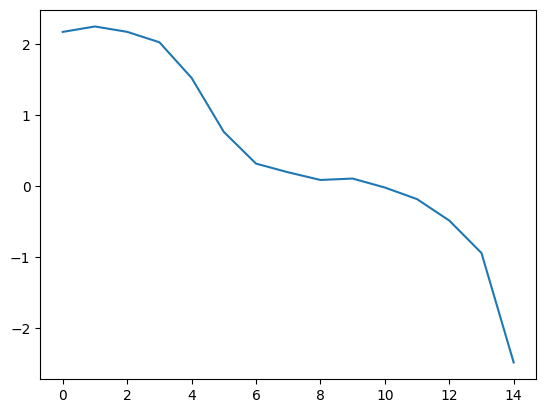

In [61]:
plt.plot( model.head.weight.detach().cpu().numpy().flatten() )

In [26]:
embeddings = np.load('oof/embbedings_fm10.npy')
embeddings.shape

(1855603, 256)

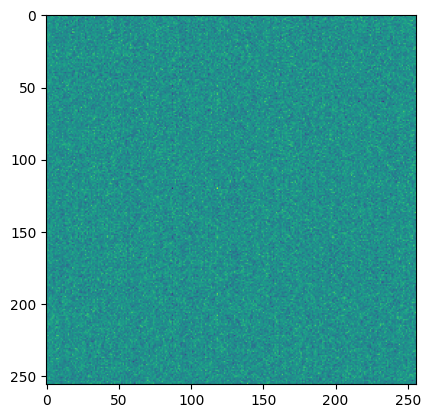

In [27]:
import cv2
import matplotlib.pyplot as plt
plt.imshow(embeddings[:256])

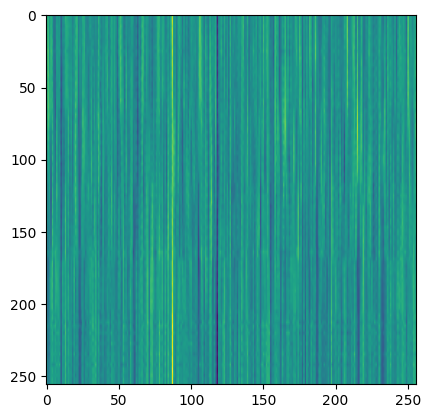

In [38]:
plt.imshow(cv2.resize(embeddings_hour[:105], (256, 256)))

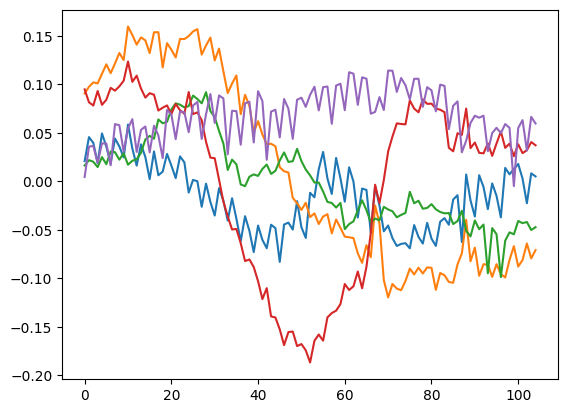

In [63]:
plt.plot(embeddings_hour[:105, 0])
plt.plot(embeddings_hour[:105, 1])
plt.plot(embeddings_hour[:105, 2])
plt.plot(embeddings_hour[:105, 3])
plt.plot(embeddings_hour[:105, 4])

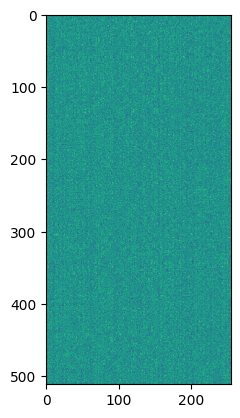

In [41]:
plt.imshow(cv2.resize(embeddings, (256,512)))

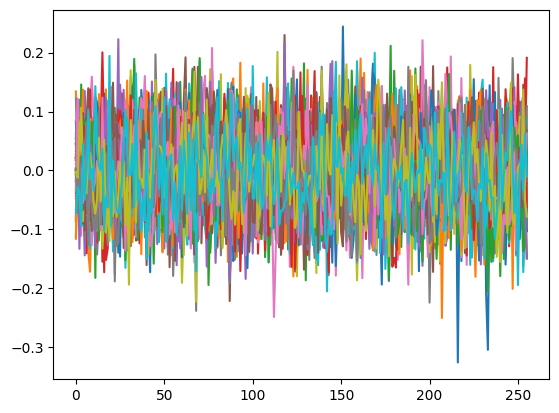

In [42]:
for i in range(50,100):
    plt.plot(embeddings[i])

In [43]:
def normalize(v):
    if len(v.shape)>1:
        return v / np.sqrt(np.sum(v**2, 1 , keepdims=True))
    else:
        return v / np.sqrt(np.sum(v**2))

In [44]:
%%time
import cuml
from cuml.manifold import TSNE
tsne    = TSNE(n_components=2, perplexity=50, learning_rate=200, n_neighbors=4*50)
tsne_aid0 = tsne.fit_transform(embeddings)
tsne_aid0.shape, np.min(tsne_aid0), np.max(tsne_aid0)

/usr/local/lib/python3.8/dist-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [15:49:55.586024] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 9min 26s, sys: 5.63 s, total: 9min 32s
Wall time: 9min 32s


((1855603, 2), -155417.75, 74853.2)

In [51]:
tsne_aid0 = np.clip(tsne_aid0, -5000, 5000)

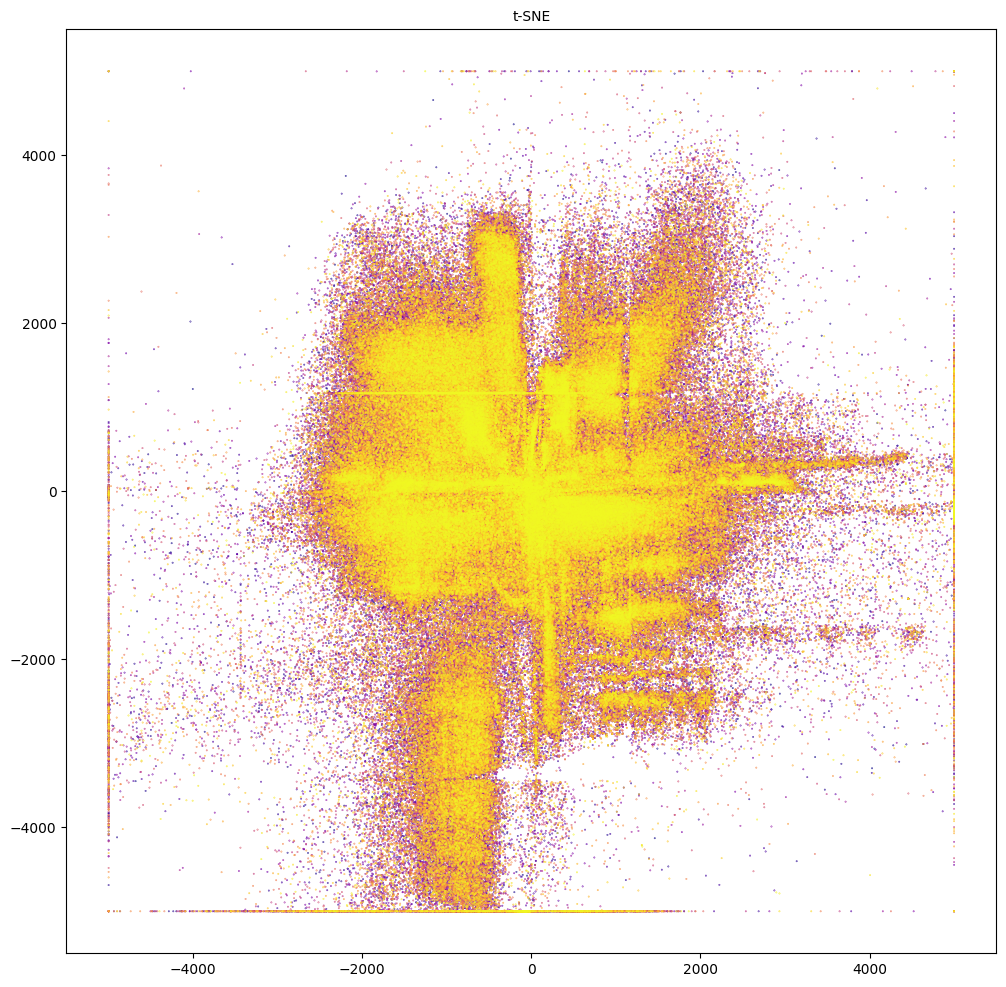

In [52]:
x = np.arange(tsne_aid0.shape[0])//7277
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=x, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

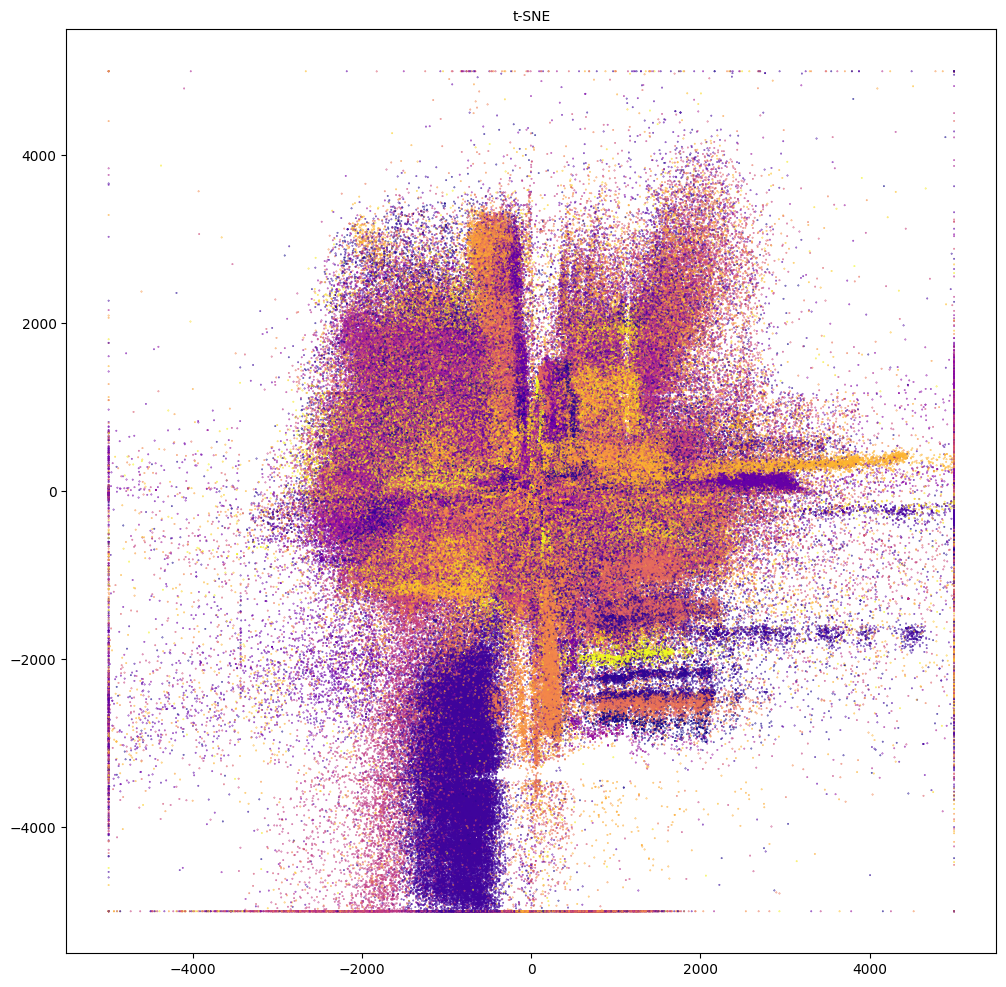

CPU times: user 1min 27s, sys: 2.87 s, total: 1min 30s
Wall time: 1min 30s


In [56]:
%%time
km1 = cuml.KMeans(n_clusters=128, max_iter=4000, n_init=8, oversampling_factor=4.0, max_samples_per_batch=65536)
km1.fit(normalize(embeddings))
#np.unique(km1.labels_, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=km1.labels_, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

In [58]:
np.unique(km1.labels_, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32),
 array([19227, 15737, 23065,  6784, 13949, 14881, 17639, 12619, 13316,
        18816, 11392, 27397, 55615, 24184, 11430, 13220, 12724,  8406,
        12675, 12014, 20829,  4351, 21093, 12925, 23063, 32122,  4664,
        17406, 12565, 18407, 24237, 17354,  5096, 20

In [76]:
!mkdir embeddings

def torch_similarity(emb, emb_global, topk=50, batch_size=256):
    if type(emb_global) == np.ndarray:
        emb_global = torch.as_tensor(emb_global)
        emb_global = torch.nn.functional.normalize(emb_global, p=2.0, dim=1, eps=1e-12)
        embT = torch.transpose(emb_global, 0, 1).to('cuda')
    else:
        emb_global = torch.nn.functional.normalize(emb_global, p=2.0, dim=1, eps=1e-12)
        embT = torch.transpose(emb_global, 0, 1).to('cuda')

    if type(emb) == np.ndarray:
        emb = torch.as_tensor(emb)

    NN = []
    NNdist = []
    for batch in tqdm(range(0, emb.shape[0], batch_size)):
        emb_batch = torch.nn.functional.normalize(emb[batch:batch+batch_size].to('cuda'), p=2.0, dim=1, eps=1e-12)
        res = emb_batch @ embT
        dist, ind = torch.topk(res, topk, largest=True, sorted=True)
        NN.append(ind.cpu().numpy())
        NNdist.append(dist.cpu().numpy())
    NN = np.vstack(NN).astype('int32')
    NNdist = np.vstack(NNdist).astype('float32')
    
    del embT, batch, dist, ind, res
    gc.collect()
    return NN, NNdist

valind, valdist = torch_similarity(embeddings, embeddings, 100, 256)
gc.collect()

mkdir: cannot create directory ‘embeddings’: File exists


100%|██████████| 7249/7249 [04:03<00:00, 29.75it/s]


0